In [2]:
from copy import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [8]:
data=pd.read_csv("Classification.csv")
# adding bias component to the data;
data['bias']=1
# Change label from 0/1 to -1/1
data.y=data.y.apply(lambda t:2*t-1)
def split_data(data,frac=.8):
    # shuffle data
    data=data.sample(frac=1)
    x=data.drop('y',axis=1).to_numpy()
    y=np.reshape(data.y.to_numpy(),(x.shape[0],1))
    #splitting 
    split=int(frac*data.shape[0])
    train_data,train_label,test_data,test_label=x[:split],y[:split],x[split:],y[split:]
    return (train_data,train_label,test_data,test_label)

In [9]:
# q1
train_data,train_label,test_data,test_label=split_data(data,frac=.77)
print("Number of features: ",train_data.shape[1]-1)
print("Number of classes: ", len(data.y.unique()))
print(train_data.shape[0], " training examples.")
print(test_data.shape[0], " testing examples.")
print("Dataset contains missing values?",data.isnull().values.any())

Number of features:  2
Number of classes:  2
231  training examples.
69  testing examples.
Dataset contains missing values? False


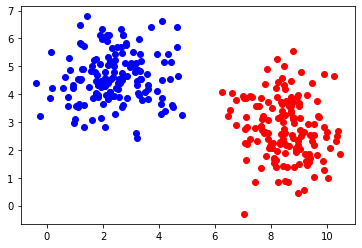

In [10]:
#q2
colors = {-1:'b', 1:'r'}
fig,ax=plt.subplots()
for i in range(data.shape[0]):
    ax.scatter(data.x_1[i],data.x_2[i],color=colors[data.y[i]])
plt.savefig('data.png')
plt.show()

In [11]:
#q5
def perceptron(X,y):
    # Note: y should be -1 and 1 array!
    w=np.random.rand(X.shape[1],1)
    while np.sum(X.dot(w)*y<=0)!=0:
        for i in range(X.shape[0]):
            if X[i].dot(w)*y[i]<0:
                w=w+y[i][0]*np.vstack(X[i])
    return w
w_perceptron=perceptron(train_data,train_label)
print("Training error: ",
      np.sum(train_data.dot(w_perceptron)*train_label<=0)/train_data.shape[0])
print("Accuracy of model (1- generalization error) :", 
      np.sum(test_data.dot(w_perceptron)*test_label>0)/test_data.shape[0])

Training error:  0.0
Accuracy of model (1- generalization error) : 1.0


## From now on, the data variable contains the noisy labels

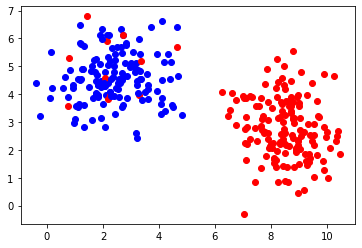

In [16]:
# q6: disturbing data.
class1_size=data.groupby('y').size()[-1]
indices=data.loc[data.y==-1,:].index
indices_to_disturb=np.random.choice(indices,round(class1_size*0.07),replace=False)
data.loc[indices_to_disturb,'y']=1
# Split data
train_data,train_label,test_data,test_label=split_data(data,frac=.77)
# Plot data
colors = {-1:'b', 1:'r'}
fig,ax=plt.subplots()
for i in range(data.shape[0]):
    ax.scatter(data.x_1[i],data.x_2[i],color=colors[data.y[i]])
plt.savefig('disturb.png')
plt.show()

In [17]:
#q7
def pocket(X,y,max_iter=1e3):
    # Note: y should be -1 and 1 array!
    w=np.random.rand(X.shape[1],1)
    loss=np.sum(X.dot(w)*y<=0)
    t=0
    w_best=copy(w)
    best_loss=loss
    while loss!=0 and t<max_iter:
        for i in range(X.shape[0]):
            if X[i].dot(w)*y[i]<0:
                w=w+y[i][0]*np.vstack(X[i])
        loss=np.sum(X.dot(w)*y<=0)
        if best_loss>loss:
            w_best=copy(w)
            best_loss=loss
        t+=1
    return w_best
w=pocket(train_data,train_label,100)
print("Empirical Risk: ",
      np.sum(train_data.dot(w)*train_label<=0)/train_data.shape[0])
print("Generalization Error:", 
      np.sum(test_data.dot(w)*test_label<=0)/test_data.shape[0])

Empirical Risk:  0.017316017316017316
Generalization Error: 0.10144927536231885


In [18]:
def adaline(X,y,max_iter=1e4):
    w=np.random.rand(X.shape[1],1)
    i=0
    while i<max_iter:
         for i in range(X.shape[0]):
            e=2*(X[i].dot(w)-y[i])/X.shape[0]
            if e!=0:
                w=w-e*np.vstack(X[i])
    return w
w=adaline(train_data,train_label,100)
print("Empirical Risk: ",
      np.sum((train_data.dot(w)-train_label)**2)/train_data.shape[0])
print("Generalization Error: ",
      np.sum((test_data.dot(w)-test_label)**2)/test_data.shape[0])

print("0-1 loss model on training set:", 
      np.sum(train_data.dot(w)*train_label<=0)/train_data.shape[0])
print("0-1 loss model on testing set:", 
      np.sum(test_data.dot(w)*test_label<=0)/test_data.shape[0])

Empirical Risk:  0.23965246521416755
Generalization Error:  0.5866852830527649
0-1 loss model on training set: 0.030303030303030304
0-1 loss model on testing set: 0.10144927536231885


In [25]:
# q8: bootstrap replicate
# First split data on training and testing again;
split_at=round(0.77*data.shape[0])
train_data,test_data=data.iloc[:split_at],data.iloc[split_at:]

def bootstrap_replicates(data,k):
    sets = []
    m = data.shape[0]
    for i in range(k):
        train = np.random.default_rng().choice(data,axis=0,size=m)
        test=set(map(tuple,data.to_numpy()))
        test=test-set(map(tuple,train))
        train_data=train[:,[0,1,3]]
        train_label=np.vstack(train[:,2])
        test=np.array(list(test))
        test_data=test[:,[0,1,3]]
        test_label=np.vstack(test[:,2])
        sets.append((train_data,train_label,test_data,test_label))
    return sets

def predict(w,X):
    res= X.dot(w)>0
    res= 2*res-1
    return res

def true_f(X):
    # Note: make sure in cell of 'q5' the accuracy of perceptron is  1.0;
    return predict(w_perceptron,X)

def estimate_error(X,y,X_test,y_test,sets,algorithm,risk,**args):
    # X is all data in file, y is the corresponding noisy labels;
    
    # calculate h_s for each replicate
    h=[]
    for replicate in sets:
        train_data,train_label,_,_=replicate
        w=algorithm(train_data,train_label,**args)
        h.append(w)
        
        
    # define h_bar : mode of h
    def h_bar(X):
        y = np.zeros((X.shape[0],1))
        for w in h:
            y+= (predict(w,X)+1)/2     # note: predict has values in {-1,1}
        return 2*np.round(y/len(h))-1
    
    
    # Estimate the variance of model;
    var=0.
    for i in range(len(sets)):
        var+=risk(h_bar(X_test),predict(h[i],X_test))
    var/=len(sets)
    
    # Estimate the bias of the model;
    bias=risk(true_f(X_test),h_bar(X_test))
    
    # Estimate the noise;
    noise=risk(y,true_f(X))
    
    # calculate constant c_1= 2*P_S(h_S=true_f)-1
    count=0
    true_y=true_f(X)
    for w in h:
        if np.sum(np.abs(predict(w,X)-true_y))==0:
            count+=1
    count/=len(h)
    c1=2*count-1
    
    # Calculate c_2 = 2*indicator(h_bar==true_f)-1
    c2= 1 if  np.sum(np.abs(true_y-h_bar(X)))==0 else -1
    
    return c1*noise+bias+c2*var,c1,noise,bias,c2,var
    
X_test=test_data.drop('y',axis=1).to_numpy()
y_test=np.reshape(test_data.y.to_numpy(),(X_test.shape[0],1))    
X=data.drop('y',axis=1).to_numpy()
y=np.reshape(data.y.to_numpy(),(X.shape[0],1))    
sets=bootstrap_replicates(train_data,30)

ada=estimate_error(X,y,X_test,y_test,sets,adaline,lambda x,y: np.sum((x-y)**2)/x.shape[0],max_iter=200)
poc=estimate_error(X,y,X_test,y_test,sets,pocket,lambda x,y: np.sum(x*y<=0)/x.shape[0],max_iter=200)
print(f"Adaline :{ada}; \nPocket:{poc};")

Adaline :(-0.1988405797101449, -1.0, 0.14666666666666667, 0.057971014492753624, -1, 0.11014492753623187); 
Pocket:(0.018502415458937195, 0.33333333333333326, 0.03666666666666667, 0.0, 1, 0.006280193236714976);


In [3]:
d=3
eps=.1
delta=.1
e=np.exp(1)
tmp=2*d/(eps*delta)**2
4*tmp*np.log(tmp)+4*d*np.log(2*e/d)/(eps*delta)**2

2711848.1489160364

In [88]:
m=300
(4+np.sqrt(d*np.log(2*e*m/d)))/(delta*np.sqrt(2*m))

3.407580066820666

In [16]:
from numpy import log ,exp

d=3
eps=.5
delta=.0001
e=exp(1)
4*(32*d/eps**2)*log(64*d/eps**2)+(8/eps**2)*(8*d*log(e/d)+2*log(4/delta)),8*d/eps**2


(10807.311415335866, 96.0)

In [60]:
#q17
def armijo(w,grad,X,y,eps=0.5,eta=2.33):
    alpha=1e-7
    norm2=-np.sum(grad**2)
    phi0=risk(w,X,y)
    while risk(w-alpha*grad,X,y)    > eps*alpha*norm2+phi0:
        alpha/=eta
    while risk(w-alpha*grad,X,y)    <= eps*alpha*norm2+phi0:
        alpha*=eta
    return alpha/eta
    
def risk(w,X,y):
    return np.sum(np.log(1+np.exp(-X.dot(w)*y)))/X.shape[0]

def gradient_risk(w,X,y):
    return np.vstack(-np.sum(X*y/(1+np.exp(X.dot(w)*y)),axis=0)/X.shape[0])

def logistic_regression(X,y,delta=1e-4):
    w=np.random.rand(X.shape[1],1)
    grad=gradient_risk(w,X,y)
    while np.linalg.norm(grad)>delta:
        step=armijo(w,grad,X,y)
        w=w-step*grad
        grad=gradient_risk(w,X,y)
    return w

In [15]:
w=logistic_regression(train_data,train_label)

print('Empirical risk:',risk(w,train_data,train_label))
print('Generalization error:',risk(w,test_data,test_label))

# print("Accuracy of model on training set:", 
#       np.sum(train_data.dot(w)*train_label>0)/train_data.shape[0])
# print("Accuracy of model:", 
#       np.sum(test_data.dot(w)*test_label>0)/test_data.shape[0])

Empirical risk: 0.17635746488669832
Generalization error: 0.1968234013840082


In [23]:
#q18
def regularized_armijo(w,grad,X,y,lmd):
    # Hyperparameters
    eps=np.random.rand()
    eta=1+np.random.rand()*5
    alpha=1e-5
    
    norm2=-np.sum(grad**2)
    phi0=regularized_risk(w,X,y,lmd)
    while risk(w-alpha*grad,X,y)    > eps*alpha*norm2+phi0:
        alpha/=eta
    while risk(w-alpha*grad,X,y)    <= eps*alpha*norm2+phi0:
        alpha*=eta
    return alpha/eta

def regularized_risk(w,X,y,lmd):
    return np.sum(np.log(1+np.exp(-X.dot(w)*y)))/X.shape[0]+lmd*np.sum(w**2)/w.shape[0]

def regularized_gradient_risk(w,X,y,lmd):
    return np.vstack(-np.sum(X*y/(1+np.exp(X.dot(w)*y)),axis=0)/X.shape[0])+2*lmd*w/w.shape[0]

def regularized_logistic_regression(X,y,delta=1e-4,lmd=1e-3):
    w=np.random.rand(X.shape[1],1)
    grad=regularized_gradient_risk(w,X,y,lmd)
    while np.linalg.norm(grad)>delta:
        step=armijo(w,grad,X,y,lmd)
        w=w-step*grad
        grad=regularized_gradient_risk(w,X,y,lmd)
    print('Regularized Empirical risk:',regularized_risk(w,X,y,lmd))
    return w

In [24]:
w=regularized_logistic_regression(train_data,train_label)
print('Empirical risk:',risk(w,train_data,train_label))
print('Generalization Error:',risk(w,test_data,test_label))
# print("Accuracy of model on training set:", 
#       np.sum(train_data.dot(w)*train_label>0)/train_data.shape[0])
# print("Accuracy of model:", 
#       np.sum(test_data.dot(w)*test_label>0)/test_data.shape[0])

Regularized Empirical risk: 0.17735509977737007
Empirical risk: 0.17647599157850816
Generalization Error: 0.19727836570928547
